Crypto ML research case: searching alfa from Twitter (X) sentiment, order book data, and volume

TODO:

- select token pairs and split into categories based on exchange, volume (30 days) and TVL 
- fetch token data from a single exchange for several different tokens (develop solution where time frames and token symbols can be adjusted)
- fetch twitter feed relating to the specified tokens, with timestamp dimension included
- train and test regression models for price predictions
- train and test classifiers for long/short actions

In [244]:
#libraries

import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [152]:
api_key = "tradingstrategy-5681d3a216271b1e5c7f2fc1bf238d7cccb72785bb6bfa121d2ac25593066251"
api_url = "https://tradingstrategy.ai/api/"

In [153]:
chains = requests.get(api_url + "chains")
chain_names = [chain["chain_name"] for chain in chains.json()]
chain_slugs = [chain["chain_slug"] for chain in chains.json()]
chain_slug_string = ",".join(chain_slugs)

print(chain_slug_string)
selected_chain = chain_slugs[0]
print(selected_chain)

ethereum,binance,polygon,avalanche,arbitrum
ethereum


In [154]:
# get Ethereum exchanges without zero volume 

eth_exchanges = requests.get(api_url + f"exchanges?chain_slug={selected_chain}&sort=usd_volume_30d&direction=desc&filter_zero_volume=true")
print(eth_exchanges.json())
eth_exc_names = [exc["exchange_slug"]for exc in eth_exchanges.json()["exchanges"]]
eth_exc_vol = [exc["usd_volume_30d"]for exc in eth_exchanges.json()["exchanges"]]
eth_exc_id = [exc["exchange_id"]for exc in eth_exchanges.json()["exchanges"]]
df_eth_exc = pd.DataFrame(data={"vol":eth_exc_vol, "name": eth_exc_names}, index=eth_exc_id)
df_eth_exc.head()

{'exchanges': [{'exchange_id': '3681', 'exchange_slug': 'uniswap-v3', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Uniswap v3', 'chain_id': 1, 'address': '0x1f98431c8ad98523631ae4a59f267346ea31f984', 'usd_volume_30d': 18885715528.32975, 'exchange_type': 'uniswap_v3', 'notable': True, 'pair_count': 20224}, {'exchange_id': '1', 'exchange_slug': 'uniswap-v2', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Uniswap v2', 'chain_id': 1, 'address': '0x5c69bee701ef814a2b6a3edd4b1652cb9cc5aa6f', 'usd_volume_30d': 5090370764.882475, 'exchange_type': 'uniswap_v2', 'notable': True, 'pair_count': 308411}, {'exchange_id': '22', 'exchange_slug': 'sushi', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Sushi', 'chain_id': 1, 'address': '0xc0aee478e3658e2610c5f7a4a2e1777ce9e4f2ac', 'usd_volume_30d': 245168392.4543597, 'exchange_type': 'uniswap_v2', 'notable': True, 'pair_count': 3913}, {'exchange_id': '314', 'exchang

,vol,name
3681,1.888572e+10,uniswap-v3
1,5.090371e+09,uniswap-v2
22,2.451684e+08,sushi
314,1.287135e+08,twap
231,2.303298e+07,shiba-swap


Select three highest volume exchanges

In [155]:
selected_exchanges = df_eth_exc.iloc[0:5,:]
print(selected_exchanges)

               vol        name
3681  1.888572e+10  uniswap-v3
1     5.090371e+09  uniswap-v2
22    2.451684e+08       sushi
314   1.287135e+08        twap
231   2.303298e+07  shiba-swap


Selected pairs for token ETH (WETH)

In [167]:
exc_slug_string = ",".join(selected_exchanges["name"].to_list())
pairs_n = 20
pairs = requests.get(api_url + f"pairs?exchange_slugs={exc_slug_string}&chain_slugs={chain_slug_string}&page=0&page_size={pairs_n}&sort=volume_30d&direction=desc&filter=min_liquidity_1M&eligible_only=true&format=json")
pair_id = [pair["pair_id"] for pair in pairs.json()["results"]]
pair_slug = [pair["pair_slug"] for pair in pairs.json()["results"]]
pair_exc = [pair["exchange_slug"] for pair in pairs.json()["results"]]
pair_chain = [pair["chain_slug"] for pair in pairs.json()["results"]]
pair_df = pd.DataFrame(data={"pair_slug" : pair_slug, "pair_exchange": pair_exc}, index=pair_id)
pair_df

,pair_slug,pair_exchange
239,eth-usdt,uniswap-v2
1,eth-usdc,uniswap-v2
3366033,beam-eth-3,uniswap-v2
3212619,olas-eth,uniswap-v2
3511613,vec-eth,uniswap-v2
3017331,troll-eth,uniswap-v2
608,mkr-dai,uniswap-v2
3226046,mog-eth,uniswap-v2
3265485,trump-eth,uniswap-v2
36103,ilv-eth,sushi


Get OHLCV data for pairs in all exchanges in the specified chain for selected timeframe

239,1,3366033,3212619,3511613,3017331,608,3226046,3265485,36103,3476323,3067777,33873,3223549,3010484,3528917,349,29535,3377643,3467561


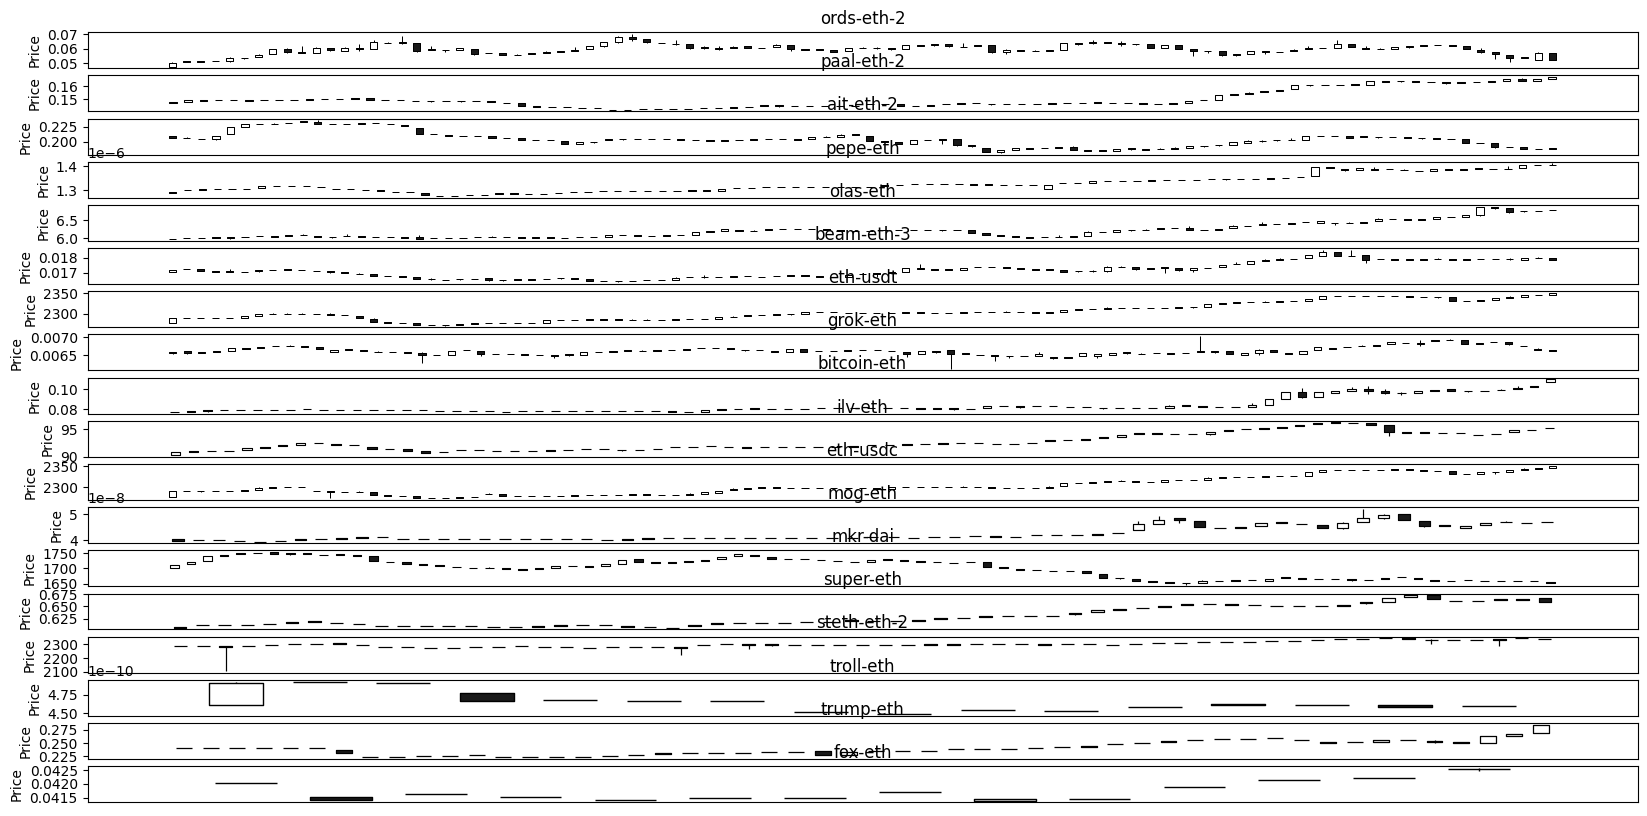

In [231]:
start_time = "2024-01-01"
end_time = "2024-01-02"    
time_bucket = "15m"
pair_id_string = ",".join(pair_df.index.values.astype(str))
data_req = requests.get(api_url + f"candles?pair_ids={pair_id_string}&time_bucket={time_bucket}&candle_type=price&start={start_time}&end={end_time}")
data = data_req.json()
ohlcv_dfs = {}

for key, value in data.items():
    ts = [val["ts"] for val in value]
    open = [val["o"] for val in value]
    high = [val["h"] for val in value]
    low = [val["l"] for val in value]
    close = [val["c"] for val in value]
    volume = [val["v"] for val in value]
    df = pd.DataFrame(data={"Open": open, "High": high, "Low": low, "Close": close, "Volume": volume}, index=pd.to_datetime(ts, format='%Y-%m-%dT%H:%M:%S'))
    ohlcv_dfs[key] = df

fig, axs = plt.subplots(len(ohlcv_dfs.keys()), figsize=(20,10))

for i, k in enumerate(ohlcv_dfs.keys()):
    mpf.plot(ohlcv_dfs[k], type="candle", volume=False, ax=axs[i])
    axs[i].set_title(pair_df.loc[int(k), "pair_slug"])
    axs[i].set_xticks([])

plt.show()

Dataset analysis without Twitter data

In [243]:

#master dataframe

print(list(ohlcv_dfs.keys()))
columns = list(ohlcv_dfs[list(ohlcv_dfs.keys())[0]].columns)
print(columns)
all_df = pd.DataFrame(data={}, index=ohlcv_dfs[list(ohlcv_dfs.keys())[0]].index.values)
print(all_df)
for key, value in ohlcv_dfs.items():
    for col in columns:
        all_df[str(key) + "_" + str(col)] = ohlcv_dfs[key][col]

['3476323', '3223549', '3467561', '3010484', '3212619', '3366033', '239', '3377643', '3067777', '36103', '1', '3226046', '608', '33873', '29535', '3017331', '3265485', '349']
['Open', 'High', 'Low', 'Close', 'Volume']
Empty DataFrame
Columns: []
Index: [2024-01-01 00:00:00, 2024-01-01 00:15:00, 2024-01-01 00:30:00, 2024-01-01 00:45:00, 2024-01-01 01:00:00, 2024-01-01 01:15:00, 2024-01-01 01:30:00, 2024-01-01 01:45:00, 2024-01-01 02:00:00, 2024-01-01 02:15:00, 2024-01-01 02:30:00, 2024-01-01 02:45:00, 2024-01-01 03:00:00, 2024-01-01 03:15:00, 2024-01-01 03:30:00, 2024-01-01 03:45:00, 2024-01-01 04:00:00, 2024-01-01 04:15:00, 2024-01-01 04:30:00, 2024-01-01 04:45:00, 2024-01-01 05:00:00, 2024-01-01 05:15:00, 2024-01-01 05:30:00, 2024-01-01 05:45:00, 2024-01-01 06:00:00, 2024-01-01 06:15:00, 2024-01-01 06:30:00, 2024-01-01 06:45:00, 2024-01-01 07:00:00, 2024-01-01 07:15:00, 2024-01-01 07:30:00, 2024-01-01 07:45:00, 2024-01-01 08:00:00, 2024-01-01 08:15:00, 2024-01-01 08:30:00, 2024-01-01 